# Production Technology
### Code for Project 1. Anna Livia, Jens og Freja 

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
print(os.listdir())
import project_1 as est
from numpy import linalg as la
from scipy.stats import chi2
from scipy import stats
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

['reg_table.tex', '2025-09_Project_1.pdf', 'project_1.py', 'firms.csv', '__pycache__', 'figure_prod_vs_intensity.png', 'read (1).ipynb', 'figure1_ldsa_vs_lemp_lcap.png']


In [2]:
dat = pd.read_csv('firms.csv')

# Descriptives

In [3]:
#Making more variables for descriptive statistics
dat['capital'] = np.exp(dat['lcap'])
dat['ansatte'] = np.exp(dat['lemp'])
dat['dsa'] = np.exp(dat['ldsa'])
dat['empl_prod'] = dat['dsa']/dat['ansatte']
dat['cap_prod'] = dat['dsa']/dat['capital']
dat['intensity'] = dat['capital']/dat['ansatte']

In [4]:
#Descriptive statistics
cols = ['lcap','lemp','ldsa',
        'capital','ansatte','dsa',
        'empl_prod','cap_prod','intensity']

def skew(x):
    return stats.skew(x, bias=False, nan_policy='omit')

def exkurt(x):
    # Excess kurtosis (Fisher) => normalfordeling har 0
    return stats.kurtosis(x, fisher=True, bias=False, nan_policy='omit')

def jb_p(x):
    jb = stats.jarque_bera(x, nan_policy='omit')
    return jb.pvalue

summ = pd.DataFrame({
    'Mean':   dat[cols].mean(),
    'SD':     dat[cols].std(ddof=1),
    'Min':    dat[cols].min(),
    'Max':    dat[cols].max(),
    'Skew':   dat[cols].apply(skew, axis=0),
    'ExKurt': dat[cols].apply(exkurt, axis=0),
    'JB p':   dat[cols].apply(jb_p, axis=0)
}).round(3)

print(summ)

latex = summ.to_latex(
    index=True,
    caption='Descriptive statistics: Mean, SD, Min, Max, Skewness, Excess Kurtosis (normal = 0) and Jarque–Bera p-value',
    label='tab:all_vars_desc',
    float_format="%.3f",
    escape=False
)
print(latex)

            Mean     SD    Min     Max   Skew  ExKurt  JB p
lcap      -0.000  1.311 -3.865   4.104  0.295  -0.133   0.0
lemp      -0.000  1.180 -3.383   3.371  0.222  -0.190   0.0
ldsa       0.000  1.232 -3.552   3.913  0.297  -0.260   0.0
capital    2.524  5.079  0.021  60.563  5.499  41.329   0.0
ansatte    2.058  3.141  0.034  29.117  3.476  15.489   0.0
dsa        2.233  3.800  0.029  50.068  4.392  28.024   0.0
empl_prod  1.090  0.532  0.249   7.240  3.331  22.394   0.0
cap_prod   1.153  0.710  0.143   8.724  2.754  14.108   0.0
intensity  1.166  0.827  0.110  13.856  5.838  64.016   0.0
\begin{table}
\caption{Descriptive statistics: Mean, SD, Min, Max, Skewness, Excess Kurtosis (normal = 0) and Jarque–Bera p-value}
\label{tab:all_vars_desc}
\begin{tabular}{lrrrrrrr}
\toprule
 & Mean & SD & Min & Max & Skew & ExKurt & JB p \\
\midrule
lcap & -0.000 & 1.311 & -3.865 & 4.104 & 0.295 & -0.133 & 0.000 \\
lemp & -0.000 & 1.180 & -3.383 & 3.371 & 0.222 & -0.190 & 0.000 \\
ldsa & 0.000 &

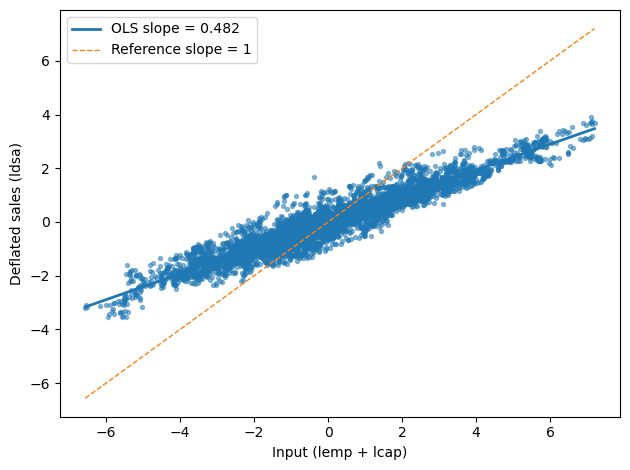

In [5]:
#Return to scale graphical illustration
x = (dat['lemp'] + dat['lcap']).to_numpy()
y = dat['ldsa'].to_numpy()

b, a = np.polyfit(x, y, 1)

plt.figure()
plt.scatter(x, y, s=8, alpha=0.5)
xg = np.linspace(x.min(), x.max(), 200)
plt.plot(xg, a + b*xg, linewidth=2, label=f'OLS slope = {b:.3f}')

# Reference-linje med hældning 1, flyttet så den går gennem (x̄, ȳ)
plt.plot(xg, (y.mean() - x.mean()) + 1.0*xg, linestyle='--', linewidth=1, label='Reference slope = 1')

plt.xlabel('Input (lemp + lcap)')
plt.ylabel('Deflated sales (ldsa)')
plt.legend()
plt.tight_layout()
plt.savefig('figure1_ldsa_vs_lemp_lcap.png', dpi=300)
plt.show()

### Converting data to numpy format 

In [6]:
dat.ldsa.values.shape

(5292,)

In [7]:
#Define N and T for our models 
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


In [8]:
#Define sales as our dependent variable 
y = dat.ldsa.values.reshape((N*T,1))

#Makes variables
ones = np.ones((N*T,1)) 
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])
label_y = 'log_omsætning'
label_x = ['const', 'log_ansatte', 'log_kapital']

#Rename columns for easier reading
rename_dict = {'year': 'aar', 'ldsa':'log_omsætning', 'lemp': 'log_ansatte', 'lcap': 'log_kapital'}
dat = dat.rename(columns=rename_dict)

### OLS

In [ ]:
pooled_result = est.estimate(y, X, T=T)
est.print_table((label_y, label_x), pooled_result, title='Pooled OLS regression', floatfmt='.4f')

Pooled OLS regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0050      0.0000
log_ansatte  0.6748  0.0102     66.4625
log_kapital  0.3100  0.0091     33.9237
R² = 0.914
σ² = 0.131


### FE

In [10]:
#Create transformation matrix
Q_T = np.eye(T) - (np.ones((T,T)))/T
#Print dimension of Q_T
print(f'Dimension of Q_T: {Q_T.shape}')

#Create y and x dot using the perm function
y_dot = est.perm(Q_T, y.reshape(-1, 1))           # (N*T, 1)
x_dot = est.perm(Q_T, X)                           # (N*T, K)
#Remove constant from x_dot
x_dot = x_dot[:,1:]

# Estimate the fe model using the estimate function
label_x_fe = ['log_ansatte', 'log_kapital'] 
fe_result = est.estimate(y_dot, x_dot, robust_se=True, transform='fe', T=T)
est.print_table((label_y, label_x_fe), fe_result, title="Fixed Effects", floatfmt='.4f')

Dimension of Q_T: (12, 12)
Fixed Effects
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
log_ansatte  0.6942  0.0417     16.6674
log_kapital  0.1546  0.0299      5.1630
R² = 0.477
σ² = 0.018


### FD and Serial correlation

In [11]:
#Make FD transformation matrix
def fd_matrix(T):
    D_T = np.zeros((T-1, T))
    for i in range (T-1):
        D_T[i,i] = -1
        D_T[i, i+1] = 1
    return D_T

D_T = fd_matrix(T)

#Makes FD transformation
y_diff = est.perm(D_T, y.reshape(-1, 1))           # (N*(T-1), 1)
x_diff = est.perm(D_T, X)                           # (N*(T-1, K)

#Remove constant from x_diff
x_diff = x_diff[:, 1:]  

#Estimate FD 
fd_result = est.estimate(y_diff, x_diff, transform='fd', robust_se=True ,T=T)
label_x_fd = ['log_ansatte', 'log_kapital']

#Print results
est.print_table((label_y, label_x_fd), fd_result, title='FD regression', floatfmt='.4f')

FD regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
log_ansatte  0.5487  0.0284     19.3056
log_kapital  0.0630  0.0229      2.7460
R² = 0.165
σ² = 0.014


In [12]:
#Make function to calculate the serial correlation
def serial_corr(y, x, T):
    #Calculate the residuals
    if x.ndim == 1:
        x = x.reshape(-1, 1)     
    if y.ndim == 1:
        y = y.reshape(-1, 1)                    
    b_hat = la.inv(x.T @ x) @ (x.T @ y)
    e = y - x @ b_hat                         # (N*T,)

    # Create a lag transformation matrix (perm to lag)
    P_lag = np.eye(T-1, T)                    # (T-1 x T)

    #Lag residuals 
    E = e.reshape(-1, T)                      # (N, T)
    e_l = (E @ P_lag.T).reshape(-1, 1)        # (N*(T-1), 1)  ← regressor

    # Create a transformation matrix that removes the first time-period (perm to drop first)
    I_T = np.eye(T-1, T, k=1)                 # (T-1 x T)

    # Remove first observation of each individual (align "now" with the lag)
    e = (E @ I_T.T).reshape(-1,1)              # (N*(T-1),)

    #Calculate the serial correlation 
    N = e.shape[0] // (T-1)
    return est.estimate(e, e_l, transform='fd', T=T-1)

In [13]:
#Estimate serial correlation
corr_result = serial_corr(y_diff, x_diff, T-1)
#Print results
label_ye = 'OLS residual, e\u1d62\u209c'
label_e = ['e\u1d62\u209c\u208B\u2081']
est.print_table(
    (label_ye, label_e), corr_result, 
    title='Serial Correlation', floatfmt='.4f'
)
#Calculate p-value for test of no serial correlation
r = corr_result['b_hat'][0]
p_val = 2 * (1 - stats.norm.cdf(np.abs(r) / corr_result['se'][0]))
print(f'P-value for test of no serial correlation: {p_val[0]:8.4f}')

Serial Correlation
Dependent variable: OLS residual, eᵢₜ

          Beta      Se    t-values
-----  -------  ------  ----------
eᵢₜ₋₁  -0.1987  0.0148    -13.4493
R² = 0.039
σ² = 0.014
P-value for test of no serial correlation:   0.0000


### Test for strict exogeneity

In [14]:
#Add a lead of the emp variable,
#Create F_T to shift the emp variable one period forward
F_T = np.eye(T, T, k=1)
#Create emp_lead_full using perm function
emp_lead_full = est.perm(F_T, X[:, 2].reshape(-1, 1)) # the shape is (N*T, 1)
#Remove the last observed year for every individual
I_T = np.eye(T-1, T)

x_exo = est.perm(I_T, X)                       # (N*(T-1), K)
y_exo = est.perm(I_T, y.reshape(-1, 1))        # (N*(T-1), 1)
emp_lead = est.perm(I_T, emp_lead_full)             # (N*(T-1), 1)

#Check that the dimensions are correct
assert x_exo.shape[0] == emp_lead.shape[0] == y_exo.shape[0]

#Add union_lead to x_exo
x_exo = np.hstack((x_exo, emp_lead))                 # (N*(T-1), K+1)

#Within transform the data (demean over T-1)
Tm1 = T - 1
Q_T = np.eye(Tm1) - np.ones((Tm1, Tm1)) / Tm1          # (T-1)×(T-1)

#Apply panel-wise with your perm helper
yw_exo = est.perm(Q_T, y_exo.reshape(-1, 1)).reshape(-1,)   # (N*(T-1),)
xw_exo = est.perm(Q_T, x_exo)                               # (N*(T-1), K+1)

#Select variables (employement, capital stock, emp_lead)
xw_exo = np.hstack((xw_exo[:, 1:3], xw_exo[:, -1].reshape(-1, 1)))

#Estimate model
yw_exo = yw_exo.reshape(-1, 1)
exo_test = est.estimate(yw_exo, xw_exo, T=T-1, robust_se=True, transform='fe')

#Print results
label_exo = ['emp'] + ['cap'] + ['emp lead']
est.print_table((label_y, label_exo), exo_test, title='Exogeneity test', floatfmt='.4f')

#Test 
b = exo_test['b_hat']
cov = exo_test['cov']
se = np.sqrt(np.diag(cov))
t_stat = b[2] / se[2]
df = exo_test.get('df_resid', len(yw_exo) - len(b))
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=3))
p_value = float(p_value)  # or p_value = p_value.item()
print(f'Test statistic for H0: beta_3 = 0 is {t_stat} with p-value {p_value:8.4f}')  

Exogeneity test
Dependent variable: log_omsætning

            Beta      Se    t-values
--------  ------  ------  ----------
emp       0.6479  0.0463     13.9826
cap       0.0210  0.0374      0.5620
emp lead  0.1793  0.0450      3.9819
R² = 0.474
σ² = 0.016
Test statistic for H0: beta_3 = 0 is [3.98186774] with p-value   0.0283


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_23602/1092650640.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_value = float(p_value)  # or p_value = p_value.item()


### Test for weak exogeneity

In [15]:
R_T = np.eye(T-1, T, k=1)                      # (T-1)×T, selects columns 2..T

# Levels at time t and drop constant 
x_level_t = est.perm(R_T, X)[:, 1:]            # (N*(T-1), K-1) 

#Assemble augmented RHS: [Δk, Δl, k_t, l_t]
X_fd_exog = np.hstack([x_diff, x_level_t[:, :x_diff.shape[1]]])

labels_fd_exog = ['Δlog_ansatte', 'Δlog_kapital', 'log_ansatte_t', 'log_kapital_t']

# Estimate FD regression with levels included
fd_exog_res = est.estimate(y_diff, X_fd_exog, transform='fd', T=T-1, robust_se=True)
est.print_table((label_y, labels_fd_exog), fd_exog_res, title='Weak Exogeneity test', floatfmt='.4f')

#Test 
b = fd_exog_res['b_hat']
cov = fd_exog_res['cov']
se = np.sqrt(np.diag(cov))
t_stat = b[2] / se[2]
# frihedsgrader (hvis ikke df_resid findes, så udled dem)
df = fd_exog_res.get('df_resid', len(y_diff) - len(b))
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=3))
p_value = float(p_value)  # or p_value = p_value.item()
print(f'Test statistic for H0: beta_3 = 0 is {t_stat} with p-value {p_value:8.4f}')  

Weak Exogeneity test
Dependent variable: log_omsætning

                  Beta      Se    t-values
-------------  -------  ------  ----------
Δlog_ansatte    0.5438  0.0298     18.2672
Δlog_kapital    0.0611  0.0235      2.6032
log_ansatte_t   0.0045  0.0030      1.5021
log_kapital_t  -0.0046  0.0026     -1.7901
R² = 0.165
σ² = 0.014
Test statistic for H0: beta_3 = 0 is [1.50210937] with p-value   0.2301


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_23602/2459345494.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_value = float(p_value)  # or p_value = p_value.item()


### Test for CRS

In [16]:
######################POLS##########################
b_hat = pooled_result['b_hat']
cov   = pooled_result['cov']

ansatte_index = label_x.index('log_ansatte')
kapital_index = label_x.index('log_kapital')

b = np.asarray(b_hat).reshape(-1)   # (P,)
V = np.asarray(cov)                 # (P,P)
P = b.size
if V.shape != (P, P):
    raise ValueError(f"Kovarians har forkert form: {V.shape}, forventede {(P,P)}")

R = np.zeros((1, P))
R[0, [ansatte_index, kapital_index]] = 1.0

#Wald-test for H0: beta_kapital + beta_ansatte = 1
num = float(R @ b - 1.0)           # c'β - q, q=1
den = float(R @ V @ R.T)           # c' V c
if not np.isfinite(den) or den <= 0:
    raise ValueError("Check")

wald = (num ** 2) / den
p_value = stats.chi2.sf(wald, df=1)

print(f"Wald test statistic: {wald:.4f}")
print(f"p-value: {p_value:.4g}")

Wald test statistic: 12.9800
p-value: 0.0003148


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_23602/156260583.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = float(R @ b - 1.0)           # c'β - q, q=1
/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_23602/156260583.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  den = float(R @ V @ R.T)           # c' V c


In [17]:
######################FD##########################
b_hat = fd_result['b_hat']
cov   = fd_result['cov']

ansatte_index = label_x_fd.index('log_ansatte')
kapital_index = label_x_fd.index('log_kapital')

b = np.asarray(b_hat).reshape(-1)   # (P,)
V = np.asarray(cov)                 # (P,P)
P = b.size
if V.shape != (P, P):
    raise ValueError(f"Kovarians har forkert form: {V.shape}, forventede {(P,P)}")

R = np.zeros((1, P))
R[0, [ansatte_index, kapital_index]] = 1.0

# Wald-test for H0: beta_kapital + beta_ansatte = 1
num = float(R @ b - 1.0)           # c'β - q, q=1
den = float(R @ V @ R.T)           # c' V c
if not np.isfinite(den) or den <= 0:
    raise ValueError("Check.")

wald = (num ** 2) / den
p_value = stats.chi2.sf(wald, df=1)

print(f"Wald test statistic: {wald:.4f}")
print(f"p-value: {p_value:.4g}")

Wald test statistic: 164.4890
p-value: 1.183e-37


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_23602/2560267170.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = float(R @ b - 1.0)           # c'β - q, q=1
/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_23602/2560267170.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  den = float(R @ V @ R.T)           # c' V c
